### Step 1- Data Loading and splitting

#### Data Loading

As a first step, we load the data utilizing the provided helper file `data_loader_template.py` , providing the class  ` SLUDataLoader` which will help us to quickly parse and load the data from the `train.txt` file.

In [1]:
from templates.data_loader_template import SLUDataLoader
from templates.evaluation_template import SLUEvaluator
from collections import Counter, defaultdict
from typing import List, Tuple, Dict
import numpy as np
import os, re, math, itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from math import ceil
from sklearn.feature_selection import chi2
from wordcloud import WordCloud
import joblib

In [2]:
# Use the same relative path style as the brief recommends
loader = SLUDataLoader(data_dir="./data")  
loader.load_all_data()                     
loader.get_data_stats()
data = loader.train_data

Loading airline dialogue dataset...
Loaded 4478 samples from train.txt
Vocabulary sizes - Words: 869, Slots: 121, Intents: 21
File not found: ./data\valid.txt
Dataset loading completed!

=== Dataset Statistics ===
Training samples: 4478
Validation samples: 0
Test samples: 0
Average sequence length: 11.28
Max sequence length: 46
Min sequence length: 1

Top 5 intents:
  atis_flight: 3309 (73.9%)
  atis_airfare: 385 (8.6%)
  atis_ground_service: 230 (5.1%)
  atis_airline: 139 (3.1%)
  atis_abbreviation: 130 (2.9%)

Top 10 slot labels:
  O: 32066
  B-toloc.city_name: 3919
  B-fromloc.city_name: 3892
  I-toloc.city_name: 987
  B-depart_date.day_name: 785
  B-airline_name: 639
  I-fromloc.city_name: 632
  B-depart_time.period_of_day: 521
  I-airline_name: 379
  B-depart_date.day_number: 355


### Step 2- Data Analysis and Data Checking

#### Slot distribution

Top 10 slot tags: [('B-toloc.city_name', 3919), ('B-fromloc.city_name', 3892), ('I-toloc.city_name', 987), ('B-depart_date.day_name', 785), ('B-airline_name', 639), ('I-fromloc.city_name', 632), ('B-depart_time.period_of_day', 521), ('I-airline_name', 379), ('B-depart_date.day_number', 355), ('B-depart_date.month_name', 339)]
Least frequent slots (10):  [('I-meal_description', 1), ('B-return_date.today_relative', 1), ('B-stoploc.airport_name', 1), ('I-time', 1), ('B-time_relative', 1), ('B-state_name', 1), ('I-fare_basis_code', 1), ('B-return_date.day_name', 1), ('B-arrive_date.today_relative', 1), ('I-return_date.today_relative', 2)]
Utterances with 0 slots: 17, 1 slot: 493, 2+ slots: 3968


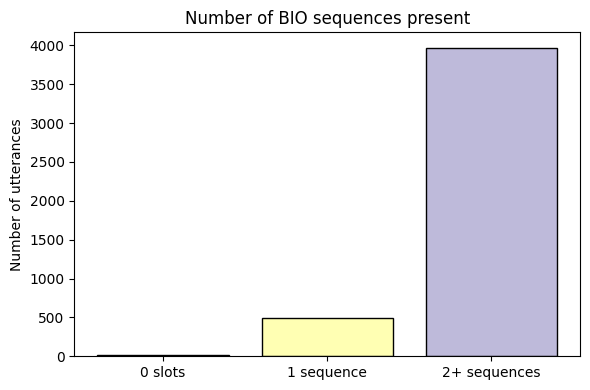

Empty utterances(5 shown) :
Phrase:  ['how', 'many', 'booking', 'classes', 'are', 'there']
Intent:  atis_quantity
Phrase:  ['what', 'airlines', 'are', 'there']
Intent:  atis_airline
Phrase:  ['display', 'all', 'fare', 'codes']
Intent:  atis_airfare
Phrase:  ['what', 'are', 'the', 'prices', 'of', 'these', 'flights']
Intent:  atis_airfare
Phrase:  ['show', 'me', 'the', 'airlines']
Intent:  atis_airline


In [3]:
def slot_distribution(samples):
    """
    samples: Tuple (list(words), list(slots), intent)
    Returns: slot_counts--> dict, slot_per_utt -->list
    Finds:
      -number of slots per utterance (stored in list)
      -count for each different kind of slot (stored in dictionary)
    """
    slot_counts = Counter()
    slot_per_utt = []
    empty_slots = []
    for words, slots, intent in samples:
        #ignoring "O" , as it will always be the most common, does not provide any information
        slot_counts.update([s for s in slots if s != "O"]) 
        slot_entities = sum(1 for s in slots if s.startswith("B-"))
        slot_per_utt.append(slot_entities)
        if not slot_entities : 
            empty_slots.append((words,slots,intent))
            
    return slot_counts, slot_per_utt, empty_slots

#Displays distribution of slots
slot_counts, slot_per_utt, empty_slots = slot_distribution(data) 
print("Top 10 slot tags:", slot_counts.most_common(10)) #most frequent
print("Least frequent slots (10): ",slot_counts.most_common()[:-11:-1])#least frequent

#Utterances containing zero, one or two+ 'meaningful' slots
zero = sum(1 for x in slot_per_utt if x == 0) #zero
one = sum(1 for x in slot_per_utt if x == 1) #one
two_plus = sum(1 for x in slot_per_utt if x >= 2) #two+
print(f"Utterances with 0 slots: {zero}, 1 slot: {one}, 2+ slots: {two_plus}")

cats   = ["0 slots", "1 sequence", "2+ sequences"] #NOTE: sequences always start with B, so each B found = one BIO sequence
values = [zero, one, two_plus]
total  = sum(values)

colors = ["#8dd3c7","#ffffb3","#bebada"]
plt.figure(figsize=(6,4))
bars = plt.bar(cats, values, color=colors, edgecolor="black")
plt.ylabel("Number of utterances")
plt.title("Number of BIO sequences present")

plt.tight_layout()
plt.savefig("slots_count_bar.png", dpi=150)
plt.show()

print("Empty utterances(5 shown) :")
for words, slots, intent in empty_slots[:5]:
    print("Phrase: ",words)
    print("Intent: ",intent)

---
#### **Observations:**
-  There are 17 utterances that have 0 slots. What this means is that out of the 4478 entries in our dataset, 15 of them contain minimimal to no information contained on the phrase (no objects). These do not help us to identify useful slots of the conversation, but they are very **useful when it comes to detecting negatives**, so **we will keep them in the training set**.
-  Most of the utterances are information dense, containing 2+ slots
-  Most of the popular tags refer to departing city and day, while the least popular refer to more specific time frames, info on prices

---

#### Sequence length analysis and Outliers

Absolute len stats | mean: 11.28 median: 11.00 std: 4.39 min: 1.00 p95: 19.00 max: 46.00


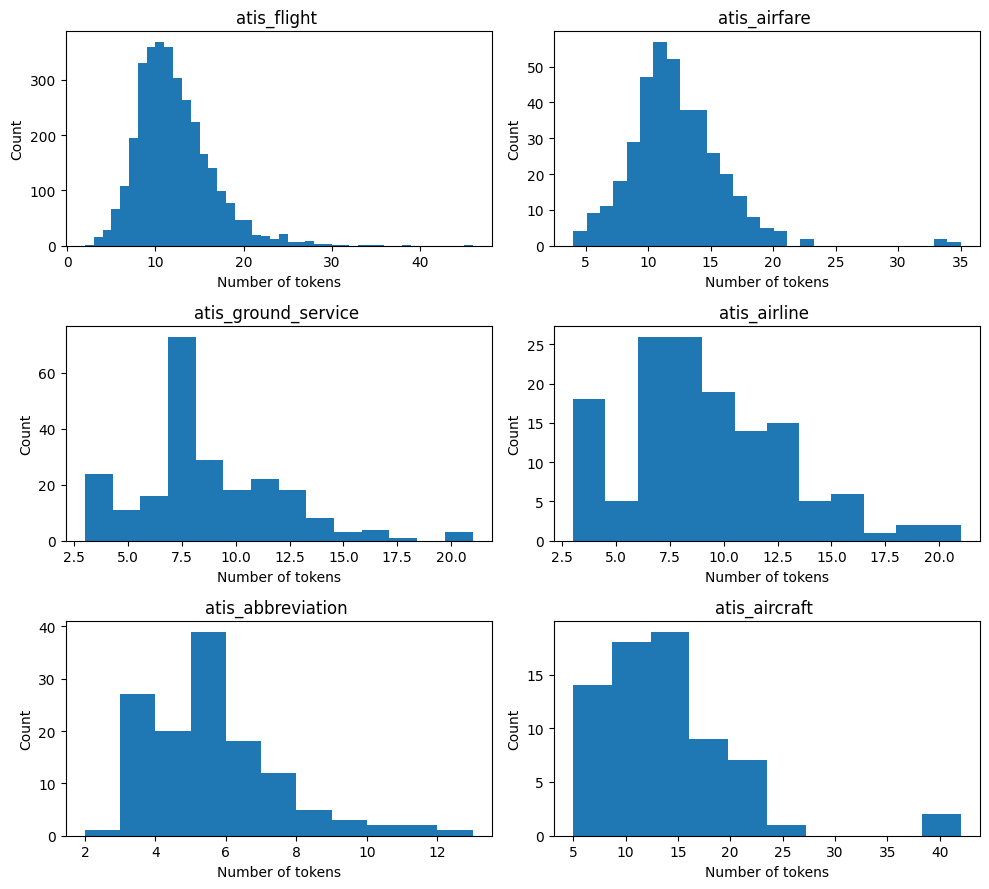

In [4]:
#ABSOLUTE LEN STATS
def seq_lengths(samples):
    lens = [len(w) for w,_,_ in samples]
    return np.array(lens)

L = seq_lengths(data)
print(f"Absolute len stats | mean: {L.mean():.2f} median: {np.median(L):.2f} std: {L.std():.2f} min: {L.min():.2f} p95: {np.percentile(L, 95):.2f} max: {L.max():.2f}")

#STATS BY INTENT
#Find Top-6 intents
intent_counts = Counter([i for _,_,i in data]).most_common(6)
top_intents = [it for it, _ in intent_counts]

#Collect lengths
lengths_by_intent = {it: [len(w) for w, s, i in data if i == it] for it in top_intents}

#Create Canvas
n = len(top_intents)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))
axes = np.atleast_1d(axes).ravel()

#Iterate over top intents
for idx, it in enumerate(top_intents):
    ax = axes[idx]
    lens = lengths_by_intent[it]
    if not lens:
        ax.set_visible(False)
        continue

    # Plot
    ax.hist(lens, bins="auto")
    ax.set_title(f"{it} ")
    ax.set_xlabel("Number of tokens")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [5]:
#Finding outliers (threshold at 3rd-97th percentile)
p3, p97 = np.percentile(L, 3), np.percentile(L, 97)
outliers_short = [(w,s,i) for (w,s,i) in data if len(w) < p3]
outliers_long  = [(w,s,i) for (w,s,i) in data if len(w) > p97]
print(f"Short outliers: {len(outliers_short)} | Long outliers: {len(outliers_long)}")

Short outliers: 69 | Long outliers: 135


---
**Observations:**
-  For all of the intents in the top 6, the distribution is somewhat gaussian, but most do show quite a strong right tail, indicating skewness. This is reflected in the outliers that we found, mostly being **long outliers** coming from the right side of the plot. Basically, we have a lot of sentences that are much longer than the average
-  Note that these are not necessarily anomalies: since we are gonna extract our features from each single word, the **length of the word doesn't really matter too much in determining the slot of each label**. On the other hand, **it might be important when determining the intent**, as a lot of those very long words might end up being multi-intent sentences, harder to label
-  Either way, we believe that removing them outright would prove detrimental to the slot classification, so we did not remove them.

---

#### Data checking and cleaning

In this section we throughly check our data. In particular we want to make sure that:

1. BIO tags are valid, meaning they always follow the sequence B-I-O-B...
2. There are no **malformed** utterances, which is when either the utterance is empty or there are some words without BIO tagging (some slots are missing or empty)
3. No duplicates exist with different intent
4. **near duplicates** (very high similarity) with different intent have correct labels

In [6]:
#1-Checking that BIO tag sequence is always valid
def bio_is_valid(slots: List[str]) -> bool:
    prev_type, prev_tag = None, "O"
    for tag in slots:
        if tag == "O":
            prev_type, prev_tag = None, "O"; continue
        if "-" not in tag: return False
        bio, typ = tag.split("-", 1)
        if bio == "B":
            prev_type, prev_tag = typ, "B"
        elif bio == "I":
            if prev_tag == "O" or prev_type != typ:
                return False
            prev_tag = "I"
        else:
            return False
    return True

invalid_bio_seq = []
for w,s,i in data:
    if not bio_is_valid(s):
        invalid_bio_train.append((w,s,i))
print("Invalid BIO sequences in TRAIN:", len(invalid_bio_seq))

Invalid BIO sequences in TRAIN: 0


In [7]:
#2- Checking whether there are malformed lines
def is_malformed(words, slots, intent):
    # length mismatch or empty fields
    if len(words) == 0 or len(words) != len(slots): return True
    if not isinstance(intent, str) or intent.strip() == "": return True
    return False

malformed = [(w,s,i) for (w,s,i) in data if is_malformed(w,s,i)]
print("Malformed entries:", len(malformed))

Malformed entries: 0


In [8]:
#3- looking for any exact duplicates with different labels
def normalize(words):
    # lowercase and keep only letters/digits/spaces
    text = " ".join(words).lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

groups = defaultdict(set)
examples = defaultdict(list)
for w,s,i in data:
    key = normalize(w)
    groups[key].add(i)
    if len(examples[key]) < 3:
        examples[key].append((w,s,i))

inconsistent = {k:v for k,v in groups.items() if len(v) > 1}
print("Exact-normalized duplicates with different intents:", len(inconsistent))

# peek
peek_key = next(iter(inconsistent)) if inconsistent else None
if peek_key:
    print(peek_key, "->", groups[peek_key], "\nExamples:", examples[peek_key])

Exact-normalized duplicates with different intents: 0


In [9]:
#4- Utilizing cos similarity, we look at any values that are almost exact matches, BUT have different labels
#Then, we can review them manually to see whether the given labelling is correct or a mistake
sample = [" ".join(w).lower() for w,_,_ in data]
labels = [i for _,_,i in data]
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2).fit_transform(sample)
S = cosine_similarity(tfidf)
pairs = []
th = 0.9  # near-duplicate threshold set at 0.9
for a in range(len(sample)):
    for b in range(a+1, len(sample)):
        if S[a,b] >= th and labels[a] != labels[b]:
            pairs.append((a,b,S[a,b], labels[a], labels[b], sample[a], sample[b]))
len(pairs), pairs 

(0, [])

---
**What we observe:**  
Our data seem to be correct on most things:
-  It does not contain any duplicates or near duplicates with different intents
-  It does not contain any invalid BIO sequences
-  It does not contain any malformed entries
---

#### Linguistic and Semantic Analysis
In this section we will be looking at the semantic data contained in the slot sequence. We aim to understand:
-  How many OOV (out of vocabolary) words are present only in validation? ( we will be doing this after creating the split)
-  What are the most common slot transition sequences?
-  Which words or phrases are most predictive for each intent?
-  Trying to identify complex cases

In [10]:
def token_counts(samples):
    c = Counter()
    for w,_,_ in samples: c.update([t.lower() for t in w])
    return c

overall_counts = token_counts(data)
print("Top 20 tokens overall:", overall_counts.most_common(20))

# Per intent (top N intents)
topN = 5
top_intents = [it for it,_ in Counter([i for _,_,i in data]).most_common(topN)]
per_intent_counts = {it: token_counts([x for x in data if x[2]==it]) for it in top_intents}
{it: per_intent_counts[it].most_common(10) for it in top_intents}
for it in top_intents:
    print(f"\nTop tokens for intent: {it}")
    for tok, cnt in per_intent_counts[it].most_common(10):
        print(f"  {tok:20s} {cnt}")

Top 20 tokens overall: [('to', 3883), ('from', 3343), ('flights', 2188), ('the', 1868), ('on', 1336), ('me', 1137), ('what', 1130), ('flight', 1067), ('boston', 964), ('show', 946), ('san', 908), ('denver', 890), ('a', 815), ('francisco', 780), ('in', 759), ('and', 704), ('atlanta', 670), ('i', 659), ('pittsburgh', 628), ('is', 596)]

Top tokens for intent: atis_flight
  to                   3212
  from                 2747
  flights              2037
  the                  1311
  on                   1155
  flight               956
  me                   908
  show                 774
  boston               746
  san                  725

Top tokens for intent: atis_airfare
  to                   385
  from                 343
  the                  251
  fare                 150
  what                 142
  is                   119
  fares                116
  trip                 104
  round                103
  me                   102

Top tokens for intent: atis_ground_service
  

---
**Observations:**
-  If we look at the **overall best tokens**, they look **very similar to atis_flight tokens**. That is because atis_flight is by far the most occuring intent.
-  **to** and **from** are tokens present across many different intents, and therefore do not seem to provide much predictive power

---

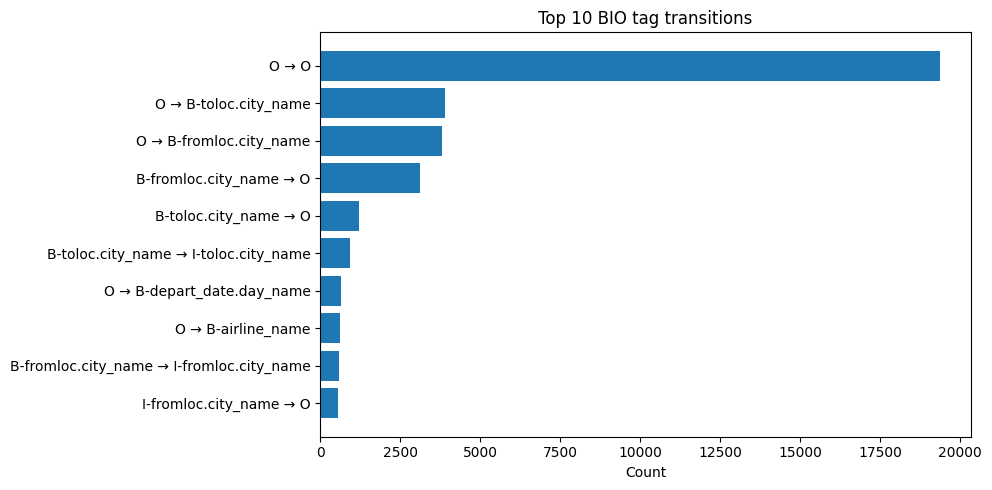

In [11]:
# Build tag set
tags = sorted({tag for _,s,_ in data for tag in s})
idx = {t:i for i,t in enumerate(tags)}
M = np.zeros((len(tags), len(tags)), dtype=int)

for _, s, _ in data:
    for a, b in zip(s[:-1], s[1:]):
        M[idx[a], idx[b]] += 1

def plot_top_transitions(M, tags, k=20 , figsize=(10,5)):
    """
    M: transition count matrix (rows=current tag, cols=next tag)
    tags: list of tag strings aligned with M's indices
    k: how many transitions to show (e.g., 10 or 20)
    """
    M_use = M.copy().astype(float)

    pairs = []
    for i, a in enumerate(tags):
        for j, b in enumerate(tags):
            v = M_use[i, j]
            if v > 0:
                pairs.append((f"{a} → {b}", v))

    # top-K
    pairs.sort(key=lambda x: x[1], reverse=True)
    top = pairs[:k]

    labels = [p[0] for p in top][::-1]
    vals   = [p[1] for p in top][::-1]

    plt.figure(figsize=figsize)
    plt.barh(labels, vals)
    plt.xlabel("Count")
    plt.title(f"Top {k} BIO tag transitions")
    plt.tight_layout()
    plt.show()

plot_top_transitions(M, tags, k=10)   # top-10 by count

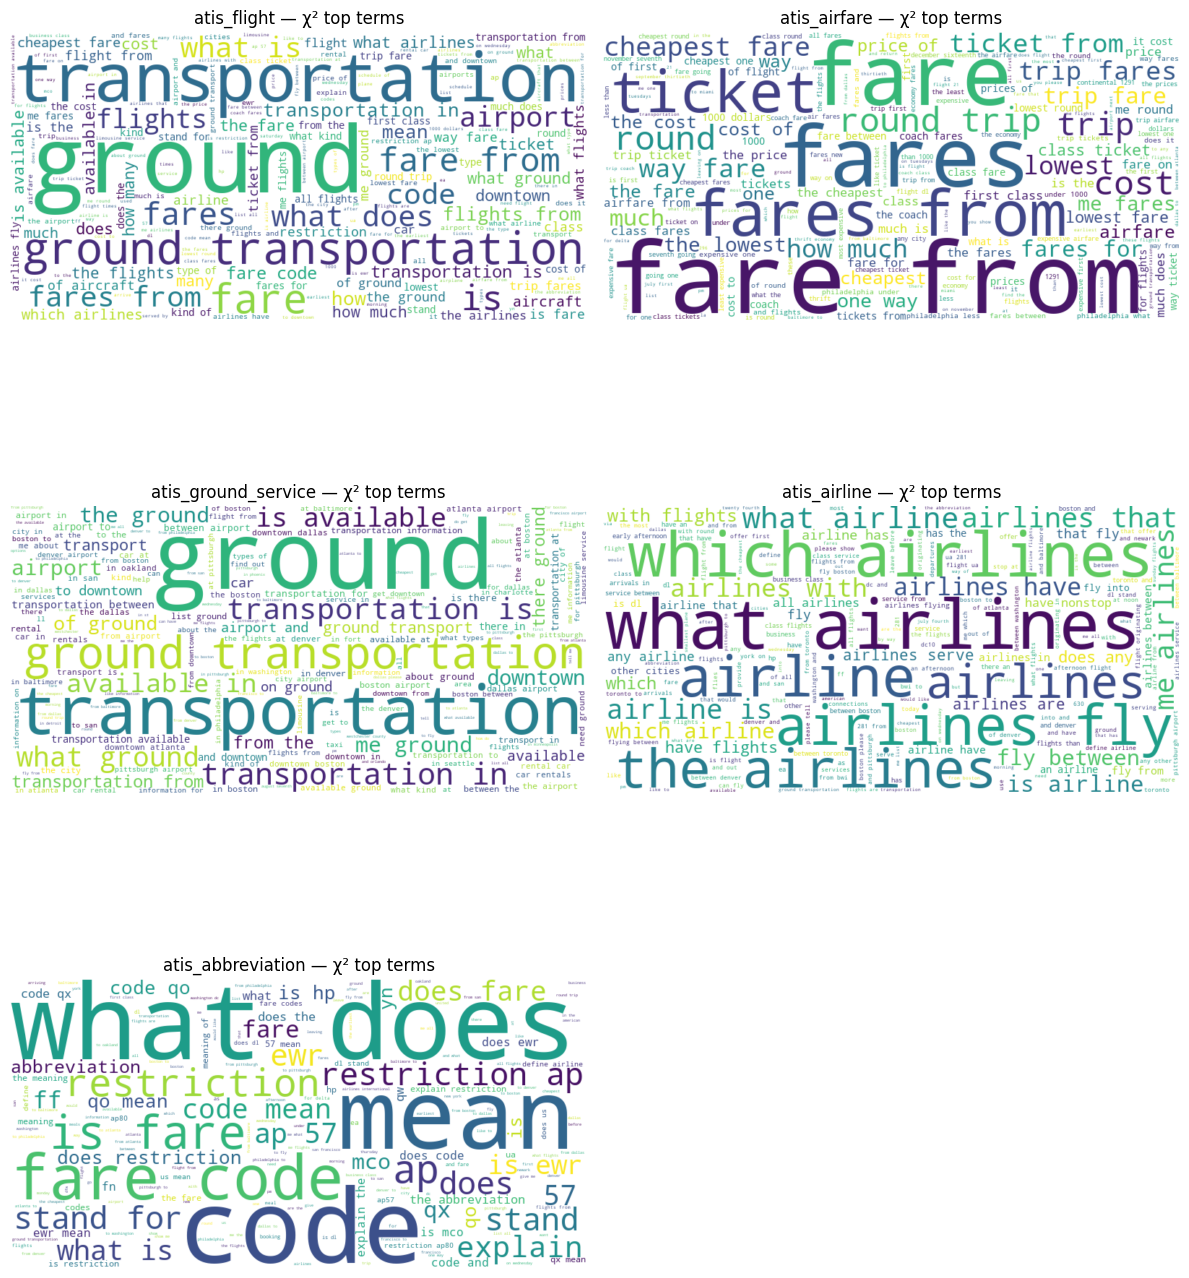

In [12]:
#WORDCLOUD OF MOST PREDICTIVE WORD FOR TOP 5 INTENTS
texts = [" ".join(w).lower() for w,_,_ in data]
y = np.array([i for _,_,i in data])

# vectorize unigrams + bigrams while droping very rare terms
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3)
X = tfidf.fit_transform(texts)
terms = np.array(tfidf.get_feature_names_out())

top_intents = [it for it,_ in Counter(y).most_common(5)]

def chi2_scores_for_intent(intent):
    mask = (y == intent).astype(int)
    chi, _ = chi2(X, mask)
    # convert scores into a frequency-like dict for WordCloud
    scores = {t: float(s) for t, s in zip(terms, chi) if s > 0}
    return scores

cols = 2
rows = (len(top_intents) + cols - 1) // cols
plt.figure(figsize=(12, 5*rows))

for k, intent in enumerate(top_intents):
    freqs = chi2_scores_for_intent(intent)
    # drop common stopwords 
    for sw in ["the", "a", "an", "to", "from", "on", "in", "of", "and", "or"]:
        freqs.pop(sw, None)

    wc = WordCloud(width=800, height=400, background_color="white", collocations=False)
    wc = wc.generate_from_frequencies(freqs)

    ax = plt.subplot(rows, cols, k+1)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{intent} — χ² top terms")

plt.tight_layout()
plt.show()

---
**Observations:**
- **atis_flight intent** seem to be **more generic** when compared to the other ones, as the tags that lead to atis_flight prediction seem to also be the tags that have strong predictive power for airfare or ground service.
- This might indicate that the atis_flight intent often co-occurs with other intents such as airfare and ground service
- What this tells us is that the model might have issues distinguishing between ground service/ airfare and flight queries

---

### Step 3- Intent based train-test split

In [13]:
def stratified_group_split_with_singletons(
    samples, test_size=0.2, random_state=42,
    key_mode="text+intent+slots"
):
    """
    samples: list of (words, slots, intent)
    Returns: train_part, valid_part

    Stratifying function will:
      1- Group identical examples so they stay together (avoid leakage).
         A group key can be:
           - "text"              : normalized utterance text only
           - "text+intent"       : text + intent
           - "text+intent+slots" : text + intent + full slot sequence (strictest, default)
      2- Compute intent labels per group (each group has a single intent).
      3- Keep 'rare' intents entirely in train (too few groups to stratify).
      4- Stratify the remaining groups by intent.
      5- Expand groups back into sample lists.
    """

    def canon_text(words):
        # Simple normalization
        return " ".join(words).strip().lower()

    def key_for(w, s, i):
        t = canon_text(w)
        if key_mode == "text":
            return (t,)
        elif key_mode == "text+intent":
            return (t, i)
        else:  # "text+intent+slots"
            return (t, i, tuple(s))

    # Build groups of identical samples
    groups = defaultdict(list)
    for idx, (w, s, i) in enumerate(samples):
        k = key_for(w, s, i)
        groups[k].append(idx)

    group_keys = list(groups.keys())
    # group-level intent label
    group_intents = []
    for k in group_keys:
        # all items in a group should share the same intent by construction
        any_idx = groups[k][0]
        group_intents.append(samples[any_idx][2])

    # Rare-vs-stratifiable 
    intent_group_counts = Counter(group_intents)
    min_needed_groups = max(2, ceil(1 / test_size))  # to ensure they are not too little and can be split
    rare_intents = {lbl for lbl, c in intent_group_counts.items() if c < min_needed_groups}

    keep_train_keys = [k for k, it in zip(group_keys, group_intents) if it in rare_intents]
    strat_keys      = [k for k, it in zip(group_keys, group_intents) if it not in rare_intents]
    strat_labels    = [it for k, it in zip(group_keys, group_intents) if k in strat_keys]

    # Stratified split on GROUPS 
    if strat_keys:
        tr_keys, va_keys = train_test_split(
            strat_keys, test_size=test_size, random_state=random_state, stratify=strat_labels
        )
    else:
        tr_keys, va_keys = [], []

    # Add the rare-intent groups to train
    tr_keys = list(tr_keys) + keep_train_keys

    # Expand groups back to sample indices
    train_idx = [i for k in tr_keys for i in groups[k]]
    valid_idx = [i for k in va_keys for i in groups[k]]

    train_part = [samples[i] for i in train_idx]
    valid_part = [samples[i] for i in valid_idx]

    # Shuffle train for randomness (valid keeps order)
    rng = np.random.default_rng(random_state)
    rng.shuffle(train_part)

    # Verbose
    dup_count = sum(len(v) for v in groups.values()) - len(groups)
    print(f"Total samples: {len(samples)} | Unique groups: {len(groups)} | Duplicates collapsed: {dup_count}")
    print(f"Test size: {test_size} | min_needed_groups per stratified intent: {min_needed_groups}")
    print(f"Rare intents kept only in TRAIN : {sorted(list(rare_intents))}")
    print(f"Final split -> Train: {len(train_part)} | Valid: {len(valid_part)}")
    
    return train_part, valid_part

train_part, valid_part = stratified_group_split_with_singletons( samples=data, test_size=0.20, random_state=42, key_mode="text+intent+slots" )

Total samples: 4478 | Unique groups: 4190 | Duplicates collapsed: 288
Test size: 0.2 | min_needed_groups per stratified intent: 5
Rare intents kept only in TRAIN : ['atis_aircraft;atis_flight;atis_flight_no', 'atis_airline;atis_flight_no', 'atis_cheapest', 'atis_ground_service;atis_ground_fare', 'atis_restriction']
Final split -> Train: 3579 | Valid: 899


In [14]:
# Build vocabs from TRAIN ONLY 
loader.train_data = train_part
loader.valid_data = valid_part
loader.build_vocabularies(loader.train_data)

Vocabulary sizes - Words: 801, Slots: 114, Intents: 21


---
**Intent distribution and stratified split**

For the split, a custom function was implemented in order to split the dataset (80-20 split) into validation and training set, while making sure that the class balance was kept the same in each of the 2. The **custom split does 2 things:**
1.  **group together exact duplicate sentences**: these should not be split between training and validation or they will cause leak
2.  **split the dataset into 2** while keeping class balance
3.   **keep the rarer intents in train only** (rarer in this case would be when the counter is less than 5)

This is the best way to ensure that the class balance is kept in both train and validation tests, so that we do not have overly optimistic/pessimistic results. In this case we have only observed 5 rare cases, so we do not expect this decision to have a meaningful impact on the analysis.

We decided **against using cross-validation** in this task, as we thought it might end up being too computationally expensive, especially when utilizing the BiLSTM + CRF method. Since we carefully stratified the validation set to keep class balance equal across training and validation, it is unlikely that we end up in a bad fold.

**NOTE:** We are still introducing a bit of an **optimistic bias** into the model by not having any of the rare labels (which the model will probably struggle to recognise) in the testing set. However, this is the best choice in this case, as it allows us to still train on such rare labels and be able to recognise them if they are present in the testing set.



---

In [15]:
# OOV: words in valid not seen in train
train_vocab = set(t.lower() for w,_,_ in train_part for t in w)
valid_vocab = set(t.lower() for w,_,_ in valid_part for t in w)
oov_valid = sorted(valid_vocab - train_vocab)
print("OOV tokens in validation:", len(oov_valid))
oov_valid[:30]

OOV tokens in validation: 68


['100',
 '1200',
 '1222',
 '150',
 '163',
 '3357',
 '345',
 '352',
 '445',
 '497766',
 '505',
 '515',
 '615',
 '730',
 '810',
 '98',
 'able',
 'afternoons',
 'america',
 'beginning',
 'begins',
 'belong',
 'bna',
 'charges',
 'continuing',
 'designate',
 'directly',
 "doesn't",
 'eye',
 'gets']

---
**Observations:**
-  There are 65 tokens that are present in validation while not present in training. Such tokens cannot be recognised and are gonna be flagged as "UNK" in our code.
-  Most of these tokens as very specific, such as a **specific value** (734 for instance) or a **specific place** (arizona)

---

### Step 4- Modelling

#### Model 1- CRF/SVC

#### Feature selection and engineering for CRF/SVC Models

In [16]:
import sklearn_crfsuite
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

#Defining features we want to use:
def word2features(sent, i):
    w = sent[i]; wl = w.lower()
    feats = {
        'bias': 1.0,
        'w.lower': wl,
        'w[:2]': wl[:2],
        'w[:3]': wl[:3],
        'w[-3:]': wl[-3:], 
        'w[-2:]': wl[-2:],
        'w.isupper': w.isupper(),
        'w.istitle': w.istitle(), 
        'w.isdigit': w.isdigit(),
    }
    #beginning of sequence feature + window feature (1 looking back)
    if i == 0: feats['BOS'] = True
    else:
        p = sent[i-1]
        feats.update({'prev_1_w.lower': p.lower(), 'prev_1_w.istitle': p.istitle(), 'prev_1_w.isupper': p.isupper()})

    #ending of sequence feature + window feature (1 looking forward)
    if i == len(sent)-1: feats['EOS'] = True
    else:
        n = sent[i+1]
        feats.update({'next_1_w.lower': n.lower(), 'next_1_w.istitle': n.istitle(), 'next_1_w.isupper': n.isupper()}) 
    return feats

def sent2features(words): return [word2features(words, i) for i in range(len(words))]
def sent2slots(slots): return slots
def sent2text(words): return " ".join(words)

---
**Features utilized**
To build the CRF / SVM models, we utilized the following features:

**Per-token features:**
- *bias* : useful to provide a baseline for the model
- *lowercase letter*
- *last 3/2 digits of the word*
- *first 3/2 digits of the word*
- *is_upper*, *is_digit*, *is_title* : identify peculiar words

**Across-token features**
- *end and beginning of sequence flags* : indicate if the word is the beginning/end of the utterance
- *look forward/backwards window* : allows the model to look 1 word forward or backwards

---

#### CRF/SVC Model evaluation

In [17]:
# Model evaluation: Support Vector Machine for intent, CRF for the slot prediction
X_slots_tr = [sent2features(w) for w,s,i in train_part]
y_slots_tr = [sent2slots(s) for w,s,i in train_part]
X_slots_va = [sent2features(w) for w,s,i in valid_part]
y_slots_va = [sent2slots(s) for w,s,i in valid_part]

X_txt_tr = [sent2text(w) for w,s,i in train_part]
y_int_tr = [i for w,s,i in train_part]
X_txt_va = [sent2text(w) for w,s,i in valid_part]
y_int_va = [i for w,s,i in valid_part]

crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions= True)
crf.fit(X_slots_tr, y_slots_tr)


intent_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=1)),
                       ('svm', LinearSVC(C=1.0))])
intent_clf.fit(X_txt_tr, y_int_tr)

#Evaluate

slot_to_id = loader.slot_vocab.get; intent_to_id = loader.intent_vocab.get
y_true_slots_ids = [[slot_to_id(tag, 0) for tag in seq] for seq in y_slots_va]
y_pred_slots_ids = [[slot_to_id(tag, 0) for tag in seq] for seq in crf.predict(X_slots_va)]
y_true_int_ids = [intent_to_id(lbl, 0) for lbl in y_int_va]
y_pred_int_ids = [intent_to_id(lbl, 0) for lbl in intent_clf.predict(X_txt_va)]
lengths_va = [len(seq) for seq in y_slots_va]

evaluator = SLUEvaluator(loader.slot_vocab, loader.intent_vocab)
results_crf = evaluator.evaluate_model(y_true_intents=y_true_int_ids, y_pred_intents=y_pred_int_ids,
                                       y_true_slots=y_true_slots_ids, y_pred_slots=y_pred_slots_ids,
                                       lengths=lengths_va, verbose=True)
results_crf
print("---------------------") #just to avoid showing the output of results_crf twice

=== Evaluation Results ===
Intent Accuracy: 0.9611
Slot Precision:  0.7385
Slot Recall:     0.7238
Slot F1:         0.7202
Entity F1:       0.8965
---------------------


---

**Results obtained:**

The model already performs at a reasonable level, with an **intent accuracy of 0.96**, and **slot F1** of:
-  **0.72 for tokens**
-  **0.89 for entities as a whole**

---

#### Model 2- BiLSTM + CRF


##### Data preparation

In [18]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# IDs (fallbacks if your vocab doesn’t include special tokens)
PAD_WORD_ID = loader.word_vocab.get("<PAD>", 0)
UNK_WORD_ID = loader.word_vocab.get("<UNK>", 1)

# For slots we’ll just pad with 0 and rely on mask/lengths
PAD_SLOT_ID = 0

tag2id = loader.slot_vocab   
id2tag = loader.id_to_slot        
n_tags  = len(tag2id)
n_words = len(loader.word_vocab)

class SlotDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        w, s, intent = self.samples[idx]
        w_ids = torch.tensor(loader.words_to_ids(w), dtype=torch.long)
        s_ids = torch.tensor(loader.slots_to_ids(s), dtype=torch.long)
        L     = torch.tensor(len(w), dtype=torch.long)
        return {"words": w_ids, "slots": s_ids, "length": L}

def collate_fn(batch):
    # dynamic pad to batch max length
    max_len = max(int(x["length"]) for x in batch) # get max length of utterance in batch
    B = len(batch)
    words = torch.full((B, max_len), PAD_WORD_ID, dtype=torch.long) #matrixes filled with zeros
    slots = torch.full((B, max_len), PAD_SLOT_ID, dtype=torch.long)
    lengths = torch.tensor([int(x["length"]) for x in batch], dtype=torch.long) #keep track of length to reconstruct original sequence
    mask = torch.zeros((B, max_len), dtype=torch.bool)
    for i, x in enumerate(batch):
        #fill up to L (length of phrase) with existing word/slot ids, leave zeros after
        L = int(x["length"])
        words[i, :L] = x["words"]
        slots[i, :L] = x["slots"]
        mask[i, :L]  = True
    return {"words": words, "slots": slots, "lengths": lengths, "mask": mask}

train_ds = SlotDataset(train_part)
valid_ds = SlotDataset(valid_part)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,  collate_fn=collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=128, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**What we did:**
-  Encoded each of the tokens and slot tags to numbers, machine readable
-  Through a custom padding function, `collate_fn()`,  we get the max_length of any word in the batch and then add a padding (zeros) based on this for the batch. We do this because **in order for BiLSTM to run we need each sequence to have the same length**
-  Boolean masks are used to tell the model "do not consider the zeros as features"
-  `Dataloader` applies padding and creates the batches with given size

##### Model definition

In [19]:
from torchcrf import CRF

#Defining the model structure (Pairing BiLSTM  neural network + CRF)
class BiLSTMCRF(nn.Module):
    #emb_dim, hidden, num_layers and dropout are tunable parameters
    def __init__(self, vocab_size, tag_size, emb_dim=100, hidden=200, num_layers=1, dropout=0.3, pad_idx=PAD_WORD_ID):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx) #learned embedding
        self.dropout = nn.Dropout(dropout)
        
        #define BiLSTM with given hyperparameters
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout = dropout #dropout between layers
        )
        self.fc = nn.Linear(hidden * 2, tag_size)   # emissions
        self.crf = CRF(tag_size, batch_first=True)

        # init
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def emissions(self, x):
        #apply embedding --> lstm --> dropout --> linear sequence
        # x: (B, T) word ids
        emb = self.embedding(x)               # (B, T, E)
        out, _ = self.lstm(emb)               # (B, T, 2H)
        out = self.dropout(out)               #dropout after final RNN Layer
        logits = self.fc(out)                 # (B, T, tag_size)
        return logits

    def forward(self, x, tags=None, mask=None):
        """
        If tags is provided -> returns negative log-likelihood loss.
        Else -> returns list of best-path tag sequences (decoded).
        """
        logits = self.emissions(x)
        if tags is not None:
            # torchcrf expects bool mask with True=valid positions
            nll = -self.crf(logits, tags, mask=mask, reduction='mean')
            return nll
        else:
            paths = self.crf.decode(logits, mask=mask)  # List[List[int]]
            return paths

**What we did:**
-  **Used learned embedding:** since we are in a very specific context (airline queries), it makes sense to let the **model learn its own embeddings** instead of using pre-trained embeddings such as GloVe and word2vec. That said, it could make sense to also test the performance of the model with different embeddings to see if performance improves.
-  LSTM is used as the RNN to be able to read each utterance in both directions, which gives additional context, especially for words in the middle
-  `linear()` layer after LSTM will convert the results to scores for each tag
-  Finally, applying `crf()` on top will also take into considerations transitions between tags find the best global path for the tags among the different possible sequences available

##### Model training and evaluation

In [20]:
model = BiLSTMCRF(vocab_size=n_words, tag_size=n_tags, emb_dim=100, hidden=200, dropout=0.3).to(device) #device has been defined before
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

def eval_on_loader(model, dl, slot_vocab, intent_vocab):
    #Function for model evalutation 
    
    model.eval()  # eval-time behavior (e.g., disable dropout)
    all_true, all_pred, all_len = [], [], []
    with torch.no_grad(): # no gradient tracking (faster, less memory)
        for batch in dl:
            words = batch["words"].to(device)
            slots = batch["slots"].to(device)
            mask  = batch["mask"].to(device)

            pred_paths = model(words, tags=None, mask=mask)  # CRF decode 
            lens = batch["lengths"].tolist()
            for i, L in enumerate(lens):
                all_true.append(slots[i, :L].tolist()) #getting back non-padded part 
                all_pred.append(pred_paths[i][:L])
                all_len.append(L)

    evaluator = SLUEvaluator(slot_vocab, intent_vocab)
    dummy = [0]*len(all_true) #dummy since we do not care about predicting intent in this model
    return evaluator.evaluate_model(dummy, dummy, all_true, all_pred, all_len, verbose=False)

#Initial values
EPOCHS = 50
patience = 3 #number of consecutive iter without improvement to stop
best_f1 = -1  
bad = 0
best_state = None
best_info  = None
best_epoch = -1

# training loop
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for batch in train_dl:
        words = batch["words"].to(device)
        slots = batch["slots"].to(device)
        mask  = batch["mask"].to(device)

        loss = model(words, tags=slots, mask=mask) #due to super inheritance, calling model calls forward() class function under the hood
        optimizer.zero_grad() #clear gradients from previous batches
        loss.backward() # compute gradients
        nn.utils.clip_grad_norm_(model.parameters(), 5.0) #normalise gradients to stabilize
        optimizer.step() #updates weights
        total_loss += loss.item()

    res_val = eval_on_loader(model, valid_dl, loader.slot_vocab, loader.intent_vocab)
    
    #Getting scores we care about from evaluator
    entity_f1 = float(res_val.get("entity_f1", float('nan')))
    token_prec = float(res_val.get('slot_precision', float('nan')))
    token_f1 = float(res_val.get('slot_f1', float('nan')))
    token_recall = float(res_val.get('slot_recall', float('nan')))
    val_f1 = token_f1 #TOKEN F1 WILL BE OUR CHOSEN METRIC METRIC
    
    #Print scores for each iteration for visual clarity
    print(f"Epoch {epoch:02d} | train_loss={total_loss/len(train_dl):.2f} | token_f1= {token_f1:.2f} | entity_F1={entity_f1:.2f} | token_precision={token_prec:.2f} | token_recall= {token_recall:.2f}")

    # Early stopping implemented
    if val_f1 > best_f1 + 1e-4:
        best_f1 = val_f1
        best_epoch = epoch
        bad = 0
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        best_info = {
            "epoch": best_epoch,
            "metrics": {
                "token_f1": token_f1,
                "token_precision": token_prec,
                "token_recall": token_recall,
                "entity_f1": entity_f1
            }
        }
    else:
        bad += 1
        if bad >= patience:
            print(f"Early stop at epoch {best_epoch} (best token-F1={best_f1:.4f})")
            break

print(f"=== Results (EPOCH: {best_epoch}) === ")
print(f"Token-F1: {best_f1:.4f} ")
print(f"Entity_F1 : {best_info["metrics"]["entity_f1"]:.4f} ")
print(f"Token_Precision : {best_info["metrics"]["token_precision"]:.4f} ")
print(f"Token_Recall : {best_info["metrics"]["token_recall"]:.4f} ")

# restore and save best
if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), "bilstm_crf_slots.pt")

C:\Users\vallo\anaconda3\envs\applied_data_analysis\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 01 | train_loss=13.21 | token_f1= 0.34 | entity_F1=0.74 | token_precision=0.39 | token_recall= 0.33
Epoch 02 | train_loss=2.08 | token_f1= 0.60 | entity_F1=0.85 | token_precision=0.66 | token_recall= 0.58
Epoch 03 | train_loss=0.91 | token_f1= 0.71 | entity_F1=0.89 | token_precision=0.76 | token_recall= 0.70
Epoch 04 | train_loss=0.51 | token_f1= 0.74 | entity_F1=0.91 | token_precision=0.79 | token_recall= 0.73
Epoch 05 | train_loss=0.30 | token_f1= 0.75 | entity_F1=0.92 | token_precision=0.79 | token_recall= 0.73
Epoch 06 | train_loss=0.17 | token_f1= 0.78 | entity_F1=0.92 | token_precision=0.80 | token_recall= 0.78
Epoch 07 | train_loss=0.10 | token_f1= 0.80 | entity_F1=0.93 | token_precision=0.83 | token_recall= 0.79
Epoch 08 | train_loss=0.07 | token_f1= 0.80 | entity_F1=0.93 | token_precision=0.84 | token_recall= 0.79
Epoch 09 | train_loss=0.06 | token_f1= 0.81 | entity_F1=0.93 | token_precision=0.84 | token_recall= 0.80
Epoch 10 | train_loss=0.04 | token_f1= 0.81 | entity_F

---
**What we did:**
-  Custom evalutation function integrating the defined `SLUEevaluator()` from the templates
-  Implemented model training, reducing the gradient after each Epoch. Early stopping was implemented to automatically stop once the entity_f1 for validation stops improving for a number of iterations. For each Epoch the model will print the results obtained and the relative loss

**Results(not tuned yet)**
-  **Even without tuning, we can see the model improved a significant amount** when compared to the previous model, making use only of CRF. On the other hand, the model already predicted Intent with very good accuracy, so we did not use a second model for that.

---

#### BILSTM-CRF Model Hypertuning

In [21]:
import itertools, math, random, time
import torch
from torch import nn
from copy import deepcopy

def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def train_one_run(config, train_samples, valid_samples, loader, device):
    """
    Train/eval a BiLSTM-CRF for one hyperparam config.
    Returns dict with metrics and (optionally) the best state_dict.
    """

    train_ds = SlotDataset(train_samples)
    valid_ds = SlotDataset(valid_samples)

    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True,  collate_fn=collate_fn)
    valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=128, shuffle=False, collate_fn=collate_fn)

    # Model
    n_words = len(loader.word_vocab)
    n_tags  = len(loader.slot_vocab)

    model = BiLSTMCRF(
        vocab_size=n_words,
        tag_size=n_tags,
        emb_dim=config["emb_dim"],
        hidden=config["hidden"],
        num_layers=config["num_layers"],
        dropout=config["dropout"],
        pad_idx=loader.PAD_ID
    ).to(device)

    # Optimizer & optional scheduler
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )
    scheduler = None
    if config.get("use_plateau_scheduler", False):
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=2, verbose=False
        )

    # Training loop with early stopping
    max_epochs = config["max_epochs"]
    patience   = config["patience"]
    best_f1    = -1.0
    best_state = None
    bad_epochs = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0.0
        for batch in train_dl:
            words = batch["words"].to(device)
            slots = batch["slots"].to(device)
            mask  = batch["mask"].to(device)

            loss = model(words, tags=slots, mask=mask)     # scalar NLL
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            total_loss += loss.item()

        # Validation
        res_val = eval_on_loader(model, valid_dl, loader.slot_vocab, loader.intent_vocab)
        
        #Getting scores we care about from evaluator
        entity_f1 = float(res_val.get("entity_f1", float('nan')))
        token_prec = float(res_val.get('slot_precision', float('nan')))
        token_f1 = float(res_val.get('slot_f1', float('nan')))
        token_recall = float(res_val.get('slot_recall', float('nan')))
        val_f1 = token_f1 #TOKEN F1 WILL BE OUR CHOSEN METRIC METRIC

        if scheduler is not None:
            scheduler.step(val_f1)

        # Early stopping bookkeeping
        if val_f1 > best_f1 + 1e-4:
            best_f1 = val_f1
            best_epoch = epoch
            bad_epochs = 0
            # clone state dict to CPU to avoid GPU mem bloat
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_info = {
                "epoch": best_epoch,
                "metrics": {
                    "token_f1": token_f1,
                    "token_precision": token_prec,
                    "token_recall": token_recall,
                    "entity_f1": entity_f1
                }
            }
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                break

    return {
        "best_token_f1": best_f1,
        "best_info": best_info,
        "best_state": best_state   # you can save this for the winning config
    }

---
**What we did:**
Defined training loop (similarly as before) that is gonna **run once per model** being hypertuned, so each model is once again being trained and going through all of the epochs until it does not improve, and then it's result will be recorded

---

In [22]:
import random
def sample_config(seed=42):
    rng = random.Random(seed)
    return {
        "emb_dim": rng.choice([100, 200]),
        "hidden": rng.choice([128, 200, 256]),
        "num_layers": rng.choice([1, 2]),
        "dropout": rng.uniform(0.15, 0.45),   # continuous
        "lr": 10 ** rng.uniform(-3.5, -2.5),  # log-uniform ~ [3e-4, 3e-3]
        "weight_decay": rng.choice([0.0, 1e-4, 3e-4]),
        "batch_size": rng.choice([32, 64]),
        "max_epochs": 30,
        "patience": 3,
        "use_plateau_scheduler": False,
    }

def random_iter_continuous(n=10, seed=42):
    rng = random.Random(seed)
    for i in range(n):
        yield sample_config(seed=rng.randint(0, 10**9))

---
**What we did:**

Defined a **random grid** in order to tune the hyperparameters without taking too long (each run takes quite a while)

**Tunable hyperparameters:**
-  *emb_dim*: controls the dimension of the embeddings, controls how much semantic "features" we are getting from each word
-  *hidden*: controls the number of hidden layers (multiplied by 2 since it is bidirectional)
-  *num_layers*: layers of LSTM stacked on top of each other
-  *dropout*: sets % (taken at random) of the LSTM outputs to 0 during training, helps generalization
-  *lr* : parameter to control regularization
-  *weight_decay* : controls by how much model parameters vary each iteration
-  *batch_size* : size of batches 

---

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use your existing split; make sure loader.vocabs are ready
# (word vocab from TRAIN only; slot vocab unified train∪valid if you chose that route)
train_samples = loader.train_data
valid_samples = loader.valid_data

results = []
run_id = 0


for cfg in random_iter_continuous(n=10, seed=123):
    run_id += 1
    t0 = time.time()
    set_seed(123)
    out = train_one_run(cfg, train_samples, valid_samples, loader, device)
    result = out["best_token_f1"]
    state = out["best_state"]
    info = out["best_info"]
    dt = time.time() - t0

    rec = deepcopy(cfg)
    rec.update({
        "run_id": run_id,
        "token_f1": result,
        "time_sec": round(dt, 2),
        "info" : info,
        "state_dict": state  # keep the best seed's weights
    })
    results.append(rec)
    print(f"[Run {run_id}] Token_F1={result:.4f} | cfg={ {k:cfg[k] for k in cfg if k not in ['max_epochs','patience']} }")

results_sorted = sorted(results, key=lambda rec: rec["token_f1"], reverse=True)
# Save the winning checkpoint
best = results_sorted[0]

print("\n=== Best config ===")
short = {k: best[k] for k in ["emb_dim","hidden","num_layers","dropout","lr","weight_decay","batch_size"]}
print(f" {short}  |  time={best['time_sec']}s")
print(f"token_F1={best['token_f1']:.4f}")
print(f"entity_F1 ={best['info']["metrics"]["entity_f1"]:.4f}")
print(f"Token_Precision ={best['info']["metrics"]["token_precision"]:.4f}")
print(f"Token_Recall ={best['info']["metrics"]["token_recall"]:.4f}")

if best.get("state_dict") is not None:
    # Rebuild a model with best config to save a clean .pt file
    best_model = BiLSTMCRF(
        vocab_size=len(loader.word_vocab),
        tag_size=len(loader.slot_vocab),
        emb_dim=best["emb_dim"],
        hidden=best["hidden"],
        num_layers=best["num_layers"],
        dropout=best["dropout"],
        pad_idx=loader.PAD_ID
    ).to("cpu")
    best_model.load_state_dict(best["state_dict"])
    torch.save({
        "state_dict": model.state_dict(),
        "config": {
            "emb_dim": 100, "hidden": 200, "num_layers": 2, "dropout": 0.3,
            "pad_idx": loader.PAD_ID,
            "vocab_size": len(loader.word_vocab),
            "tag_size": len(loader.slot_vocab),
        },
        "word_vocab": loader.word_vocab,
        "slot_vocab": loader.slot_vocab,
        "intent_vocab": loader.intent_vocab,
    }, "bilstm_crf_bundle.pt")

[Run 1] Token_F1=0.8349 | cfg={'emb_dim': 200, 'hidden': 128, 'num_layers': 2, 'dropout': 0.3886635436435022, 'lr': 0.00035749709840027927, 'weight_decay': 0.0001, 'batch_size': 64, 'use_plateau_scheduler': False}
[Run 2] Token_F1=0.8513 | cfg={'emb_dim': 100, 'hidden': 256, 'num_layers': 2, 'dropout': 0.42627095044162544, 'lr': 0.002504859061369273, 'weight_decay': 0.0003, 'batch_size': 32, 'use_plateau_scheduler': False}
[Run 3] Token_F1=0.8606 | cfg={'emb_dim': 200, 'hidden': 200, 'num_layers': 2, 'dropout': 0.2649779724849651, 'lr': 0.0016635041093864234, 'weight_decay': 0.0, 'batch_size': 64, 'use_plateau_scheduler': False}
[Run 4] Token_F1=0.8353 | cfg={'emb_dim': 100, 'hidden': 128, 'num_layers': 2, 'dropout': 0.3069224324873119, 'lr': 0.0017517979514404419, 'weight_decay': 0.0003, 'batch_size': 64, 'use_plateau_scheduler': False}
[Run 5] Token_F1=0.8534 | cfg={'emb_dim': 100, 'hidden': 200, 'num_layers': 2, 'dropout': 0.38691176897666757, 'lr': 0.0019229506333044738, 'weight_de

C:\Users\vallo\anaconda3\envs\applied_data_analysis\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4413224527903319 and num_layers=1
  warnings.warn(


[Run 9] Token_F1=0.8298 | cfg={'emb_dim': 100, 'hidden': 200, 'num_layers': 1, 'dropout': 0.4413224527903319, 'lr': 0.0013888082037772174, 'weight_decay': 0.0, 'batch_size': 64, 'use_plateau_scheduler': False}
[Run 10] Token_F1=0.8438 | cfg={'emb_dim': 200, 'hidden': 200, 'num_layers': 2, 'dropout': 0.33594665477963254, 'lr': 0.00043025068649772295, 'weight_decay': 0.0, 'batch_size': 64, 'use_plateau_scheduler': False}

=== Best config ===
 {'emb_dim': 200, 'hidden': 128, 'num_layers': 2, 'dropout': 0.4479483022277362, 'lr': 0.0012780062500160607, 'weight_decay': 0.0, 'batch_size': 64}  |  time=95.43s
token_F1=0.8642
entity_F1 =0.9375
Token_Precision =0.8822
Token_Recall =0.8615


---
**Hypertuning results**

The model was tuned over 10 different values, chosen randomly in the ranges defined for each tuning variable. Depending on the hypertuning parameter, as we can see, the **results can vary quite a bit going from 0.81 all the way to 0.86 for the token F1**. 

**The best parameters found are:**
- *embedding dimension*: 200
- *hidden layers*: 128
- *number of layers* : 2
- *dropout* : 0.45
- *regularization* : 0.0013
- *weight decay* : 0.0
- *batch size* : 64

**Resulting metrics are:**
-  *Token F1* : 0.8606
-  *Token Precision* : 0.8822
-  *Token Recall*: 0.8615
-  *Entity F1*: 0.9375

**Compared to our CRF model, we were able to improve the Token F1 vastly, getting an increase of almost 0.1 in F1 score.**

#### Predicting test data for final evaluation

Finally, we will use  our best performing model (after hypertuning) to make predictions on the testing set provided.
Initially, the test set has:
-  No slot tags
-  No intents
So it is basically just a series of utterances with no labelling whatsoever.

For each of these utterances, we will make predictions using:
-  The **svm model** found at stage 1 Modelling for the intent prediction (with an **F1 of around 0.96**)
-  The **BiLSTM + RCF best model** that was chosen after the hypertuning for the prediction of each slot (resulting **token F1 of around 0.86**)

In [24]:
DATA_DIR = "./data"
STUDENT_TEST = os.path.join(DATA_DIR, "student_test.txt") 

# 1) Read test utterances (no labels)
with open(STUDENT_TEST, "r", encoding="utf-8") as f:
    utterances = [ln.strip() for ln in f if ln.strip()]

# 2) Predict intents with the in-memory sklearn Pipeline
X_txt_te = [" ".join(u.split()).lower() for u in utterances]  # match your training preprocessing
intent_preds = intent_clf.predict(X_txt_te).tolist()

# 3) Predict slots with the in-memory BiLSTM-CRF
best_model.eval()
best_model.to(device)

def batched(seq, n):
    for i in range(0, len(seq), n):
        yield seq[i:i+n]

pred_slots_all = []
with torch.no_grad():
    for chunk in batched(utterances, 128):
        words_list = [utt.split() for utt in chunk]
        max_len = max(len(w) for w in words_list)
        B = len(words_list)

        ids  = torch.full((B, max_len), loader.PAD_ID, dtype=torch.long)
        mask = torch.zeros((B, max_len), dtype=torch.bool)

        for i, words in enumerate(words_list):
            wid = loader.words_to_ids(words)
            L = len(wid)
            ids[i, :L] = torch.tensor(wid, dtype=torch.long)
            mask[i, :L] = True

        ids  = ids.to(device)
        mask = mask.to(device)

        # CRF decode path: call model WITHOUT tags to trigger Viterbi
        paths = best_model(ids, tags=None, mask=mask)   # List[List[int]]
        # map IDs -> slot strings using loader.id_to_slot
        for seq_ids in paths:
            pred_slots_all.append([loader.id_to_slot[i] for i in seq_ids])

# 4) Write predictions to file
out_path = "A2_Task_2_pred.txt"
with open(out_path, "w", encoding="utf-8") as f:
    for utt, slots, intent in zip(utterances, pred_slots_all, intent_preds):
        words = utt.split()
        if len(slots) != len(words):                    # rare guard
            slots = slots[:len(words)] if len(slots) > len(words) else (slots + ["O"]*(len(words)-len(slots)))
        tagged = " ".join(f"{w}:{s}" for w, s in zip(words, slots))
        f.write(f"{tagged} <=> {intent}\n")

print("✅ Wrote predictions to:", out_path)

✅ Wrote predictions to: A2_Task_2_pred.txt
